## Dataset of 232 samples and model as g(x) = F1(x) + F2(x)

Data: Shaft CFD

The model consists of the sum of a linear function and a non-linear function.

The function is of the form:

$  g(x) = w * x + b + f(x)  $

where f(x) is non-linear.

This model uses the CFD shaft data.

## Web application of 6 inputs and 5 outputs

Run interactively on the web at: https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/august2022/232samples/s232F1plusF2ShaftCFD/index.html

## Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')

(9, 'i_ore_moisture_weight_perce')

(11, 'i_ore_weight_kg')

## Outputs

(19, 'o_shaft_co_utiliz')

(20, 'o_shaft_h2_utiliz')

(21, 'o_shaft_top_gas_temp_c')

(22, 'o_shaft_press_drop_pa')

(23, 'o_shaft_coke_rate_kg_thm')


In [1]:
################################################
##
## regression with ML for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000
batch_size = 10   ## 5
learning_rate =  0.1    ## 0.01   ## 1e-5 

## probably needs adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [2]:
CFD_raw_data = pd.read_csv('232.CFD.7.2022.csv') 

In [3]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
29
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_ore_moisture_weight_perce')
(10, 'i_coke_weight_kg')
(11, 'i_ore_weight_kg')
(12, 'o_production_rate_

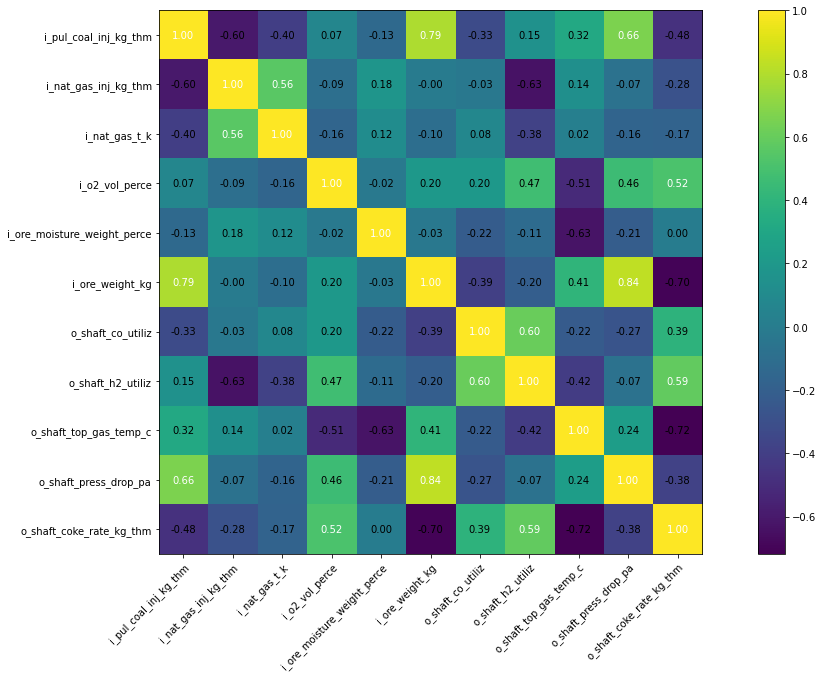

In [4]:
my_allInputs_shaft_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                            'i_ore_moisture_weight_perce', 'i_ore_weight_kg', 'o_shaft_co_utiliz', 
                            'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 
                            'o_shaft_coke_rate_kg_thm']



cm = np.corrcoef(CFD_raw_data[my_allInputs_shaft_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_shaft_names, column_names=my_allInputs_shaft_names, figsize=(20, 10))
plt.show()

In [5]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[  1.           0.          37.9        ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.          37.9        ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.          37.9        ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [ 56.         200.           0.         ...   0.2044006    0.04177462
    0.5017261 ]
 [ 56.         200.           0.         ...   0.2235308    0.03929974
    0.477466  ]
 [ 56.         200.           0.         ...   0.2289945    0.03764367
    0.4495431 ]]
(232, 29)


In [6]:
#######################################################

input_indeces  = [1, 2, 3, 4, 9, 11]
output_indeces = [19, 20, 21, 22, 23]                            

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 6)
(232, 5)
(185, 6)
(47, 6)
(185, 5)
(47, 5)


In [7]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

## Scale inputs (x)

In [8]:
###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations

## Scale outputs (y)

In [9]:
###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

## Fit and DataLoader

In [10]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [11]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

## Define NN architectures

In [12]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 5) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 5)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [13]:
#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 5) 
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 5)
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################

## Results for g(x) = F1(x) + F2(x)

F1 = Linear

F2 = Nonlinear

In [20]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.1979, grad_fn=<MseLossBackward0>)
Training R**2: 0.7331063265434896
Test loss - scaled: tensor(0.2056, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(18561080., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7653491693376531
Testing R**2 - descaled: 0.7653492008095559


## Results for Linear model

In [21]:
model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.2673, grad_fn=<MseLossBackward0>)
Training R**2: 0.46539191108882366
Test loss - scaled: tensor(0.3127, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(23870238., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.3280799761602524
Testing R**2 - descaled: 0.32808012811254905


## Results for Multi-Layer Perceptron

In [22]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.3603, grad_fn=<MseLossBackward0>)
Training R**2: 0.4367022690691648
Test loss - scaled: tensor(0.3653, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(25648754., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.5312653668651961
Testing R**2 - descaled: 0.5312654317406572


## Results for Deep Learning architecture

In [23]:
model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.4798, grad_fn=<MseLossBackward0>)
Training R**2: 0.07436249066335561
Test loss - scaled: tensor(0.4747, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(50700976., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.2350870927577801
Testing R**2 - descaled: 0.2350869772469765


## Re-Run best model and generate ONNX model

In [31]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

Training loss: tensor(0.1779, grad_fn=<MseLossBackward0>)
Training R**2: 0.7534787186764114
Test loss - scaled: tensor(0.2287, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(21466728., grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7151853276889993
Testing R**2 - descaled: 0.7151852820216978


In [32]:
for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))

**************************************************
preds, real
(41.998226, 45.36895)
(44.777866, 49.48079)
(40.427834, 50.9962)
(122911.72, 101361.73)
(559.2571, 540.866)
**************************************************
preds, real
(48.286743, 46.50771)
(46.125412, 44.8121)
(144.28717, 145.0906)
(145346.45, 147108.8)
(479.4173, 481.0346)
**************************************************
preds, real
(46.710293, 45.73427)
(42.5195, 40.75193)
(133.77765, 121.0615)
(114417.945, 135124.6)
(413.78674, 426.2504)
**************************************************
preds, real
(46.19077, 45.07049)
(44.810337, 44.2074)
(133.86014, 132.7103)
(163175.19, 163958.7)
(416.8672, 419.86374)
**************************************************
preds, real
(47.078896, 48.16658)
(42.83745, 44.19502)
(116.37714, 112.2488)
(143181.88, 152036.9)
(429.59787, 426.201)
**************************************************
preds, real
(44.821335, 45.98735)
(43.756855, 44.69968)
(136.01143, 136.1555)
(154757.52, 148

In [33]:
model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s232F1plusF2_CFDshaftSIO.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)